In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Install unrar
!apt-get install unrar -y

# Create target directory and extract the dataset
!mkdir -p /content/dataset
!unrar x -y "/content/drive/My Drive/CMATERdb 3.1.2.rar" "/content/dataset/"


Streaming output truncated to the last 5000 lines.
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000061.bmp      67%  OK 
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000062.bmp      67%  OK 
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000063.bmp      67%  OK 
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000064.bmp      67%  OK 
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000065.bmp      67%  OK 
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000066.bmp      67%  OK 
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000067.bmp      67%  OK 
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000068.bmp      67%  OK 
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000069.bmp      67%  OK 
Extracting  /content/dataset/BasicFinalDatabase/Train/201/bcc000070.bmp      67%  OK 

In [3]:
import tensorflow as tf
import cv2
import numpy as np
import os
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

In [4]:
bengali_char_map = {
    0: "অ", 1: "আ", 2: "ই", 3: "ঈ", 4:"উ", 5: "ঊ", 6: "ঋ", 7: "এ", 8: "ঐ", 9: "ও", 10: "ঔ",
    11: "ক", 12: "খ", 13: "গ", 14: "ঘ", 15: "ঙ", 16: "চ", 17: "ছ", 18: "জ", 19: "ঝ", 20: "ঞ",
    21: "ট", 22: "ঠ", 23: "ড", 24: "ঢ", 25: "ণ", 26: "ত", 27: "থ", 28: "দ", 29: "ধ", 30: "ন",
    31: "প", 32: "ফ", 33: "ব", 34: "ভ", 35: "ম", 36: "য", 37: "র", 38: "ল", 39: "শ", 40: "ষ",
    41: "স", 42: "হ", 43: "ড়", 44: "ঢ়", 45: "য়", 46: "ৎ", 47: "ং", 48: "ঃ", 49: "ঁ"
}


LeNet

In [28]:
# Image Preprocessing Function
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
    if image is None:
        print(f"Warning: Unable to read image at {image_path}")
        return None
    image = cv2.resize(image, (32, 32))  # Resize to a fixed size (32x32)
    image = image / 255.0  # Normalize pixel values to range [0, 1]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension for grayscale
    return image
# For LeNet (grayscale input)
X_test = test_images  # shape: (num_samples, 32, 32, 1)

# For VGG, ResNet, GoogLeNet (RGB input)
X_test_rgb = np.repeat(X_test, 3, axis=-1)  # Convert grayscale to RGB by repeating channels

# Dataset loading function
def load_dataset(dataset_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(dataset_path))  # Get class names sorted
    valid_extensions = ('.bmp', '.png', '.jpg', '.jpeg')  # Define valid image extensions
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_path):
            if image_name.lower().endswith(valid_extensions):  # Check if image extension is valid
                image_path = os.path.join(class_path, image_name)
                image = load_and_preprocess_image(image_path)
                if image is not None:
                    images.append(image)
                    labels.append(label)
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32), class_names

# Load the training dataset
train_images, train_labels, train_class_names = load_dataset('/content/dataset/BasicFinalDatabase/Train') # Replace with the path to your training dataset

# Load the test dataset using the same function and provide the path to your test data
test_images, test_labels, _ = load_dataset('/content/dataset/BasicFinalDatabase/Test')  # Replace with path to your test dataset


# Convert grayscale images to RGB by repeating the same channel 3 times
train_images_rgb = np.repeat(train_images, 3, axis=-1)  # shape becomes (num_images, 32, 32, 3)
test_images_rgb = np.repeat(test_images, 3, axis=-1) # You'll need to load test_images similarly

In [9]:
# Dataset paths
train_dataset_path = '/content/dataset/BasicFinalDatabase/Train'
test_dataset_path = '/content/dataset/BasicFinalDatabase/Test'

train_images, train_labels, train_class_names = load_dataset(train_dataset_path)
test_images, test_labels, test_class_names = load_dataset(test_dataset_path)


In [10]:
# Convert grayscale images to RGB by repeating the single channel 3 times along the last axis
train_images_rgb = np.repeat(train_images, 3, axis=-1)

# Do the same for test images to match the RGB format
test_images_rgb = np.repeat(test_images, 3, axis=-1)


LeNet Model

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def build_lenet(input_shape, num_classes):
    model = Sequential([
        Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape),  # Conv Layer 1
        MaxPooling2D(pool_size=(2, 2)),                                             # Max Pooling Layer 1
        Conv2D(16, kernel_size=(5, 5), activation='relu'),                          # Conv Layer 2
        MaxPooling2D(pool_size=(2, 2)),                                             # Max Pooling Layer 2
        Flatten(),                                                                  # Flatten Layer
        Dense(120, activation='relu'),                                              # Fully Connected Layer 1
        Dense(84, activation='relu'),                                               # Fully Connected Layer 2
        Dense(num_classes, activation='softmax')                                    # Output Layer
    ])
    return model
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663,602 (2.53 MB)

 Trainable params: 663,602 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model_lenet = build_lenet(input_shape=(32, 32, 1), num_classes=len(train_class_names)) # Assuming you have train_class_names

# Compile the model_lenet
model_lenet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model_lenet.fit(train_images, train_labels, epochs=30, batch_size=32, validation_data=(test_images, test_labels))
test_loss, test_acc = model_lenet.evaluate(test_images, test_labels) # Change model to model_lenet
print(f"Test Accuracy: {test_acc}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.0928 - loss: 3.5706 - val_accuracy: 0.5350 - val_loss: 1.6964
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.6001 - loss: 1.4003 - val_accuracy: 0.7083 - val_loss: 1.0157
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7464 - loss: 0.8577 - val_accuracy: 0.7493 - val_loss: 0.8439
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7977 - loss: 0.6746 - val_accuracy: 0.7950 - val_loss: 0.7075
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.8451 - loss: 0.5085 - val_accuracy: 0.8150 - val_loss: 0.6576
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8689 - loss: 0.4167 - val_accuracy: 0.8223 - val_loss: 0.6198
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8908 - loss: 0.3635 - val_accuracy: 0.8290 - val_loss: 0.5992
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9016 - loss: 0.3186 - val_

VGG MOdel

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build VGG- CNN model
def build_vgg(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         4,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,320 (762.97 KB)

 Trainable params: 65,106 (254.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 130,214 (508.65 KB)

In [36]:
import tensorflow as tf

# ... (your existing code) ...

# Assuming 'test_labels' contains your original test labels
num_classes = len(train_class_names)  # Get the number of classes
test_labels_cat = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

# Build the VGG model
model_vgg = build_vgg(input_shape=(32, 32, 3), num_classes=num_classes)

# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_vgg.fit(train_images_rgb, train_labels_cat, epochs=30, batch_size=32, validation_data=(test_images_rgb, test_labels_cat))

# Evaluate the VGG model (use model_vgg, not model)
test_loss, test_acc = model_vgg.evaluate(test_images_rgb, test_labels_cat)
print(f"Test Accuracy: {test_acc}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 213s 563ms/step - accuracy: 0.3105 - loss: 2.6693 - val_accuracy: 0.8007 - val_loss: 0.6903
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 219s 584ms/step - accuracy: 0.8849 - loss: 0.3807 - val_accuracy: 0.8863 - val_loss: 0.3698
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 266s 594ms/step - accuracy: 0.9551 - loss: 0.1361 - val_accuracy: 0.8880 - val_loss: 0.4411
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 260s 590ms/step - accuracy: 0.9700 - loss: 0.0904 - val_accuracy: 0.9047 - val_loss: 0.4073
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 267s 605ms/step - accuracy: 0.9818 - loss: 0.0542 - val_accuracy: 0.8990 - val_loss: 0.4640
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 220s 587ms/step - accuracy: 0.9837 - loss: 0.0456 - val_accuracy: 0.9063 - val_loss: 0.4517
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 260s 581ms/step - accuracy: 0.9832 - loss: 0.0589 - val_accuracy: 0.9167 - val_loss: 0.3590
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 265s 589ms/step - accuracy: 0.9910 -

ResNet- Model

In [37]:
from tensorflow.keras.layers import Add, Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = residual_block(x, 64)
    x = MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model_resnet = build_resnet((32, 32, 3), 50)  # 32x32 RGB images, 50 classes
model_resnet.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 16, 16,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 16, 16,    │     36,928 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 16, 16,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_40[0][0] 

 Total params: 165,554 (646.70 KB)

 Trainable params: 164,914 (644.20 KB)

 Non-trainable params: 640 (2.50 KB)

In [38]:
model_resnet = build_resnet(input_shape=(32, 32, 3), num_classes=num_classes)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.fit(train_images_rgb, train_labels_cat, epochs=30, batch_size=32, validation_data=(test_images_rgb, test_labels_cat))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 254s 665ms/step - accuracy: 0.1274 - loss: 3.3929 - val_accuracy: 0.0807 - val_loss: 4.1093
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 268s 682ms/step - accuracy: 0.4922 - loss: 1.7550 - val_accuracy: 0.1723 - val_loss: 3.8651
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 259s 674ms/step - accuracy: 0.6620 - loss: 1.1305 - val_accuracy: 0.6127 - val_loss: 1.2532
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 254s 678ms/step - accuracy: 0.7585 - loss: 0.8004 - val_accuracy: 0.5047 - val_loss: 1.6773
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 259s 670ms/step - accuracy: 0.8036 - loss: 0.6535 - val_accuracy: 0.2217 - val_loss: 4.0911
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 262s 671ms/step - accuracy: 0.8468 - loss: 0.5171 - val_accuracy: 0.6873 - val_loss: 0.9972
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 251s 669ms/step - accuracy: 0.8698 - loss: 0.4359 - val_accuracy: 0.6560 - val_loss: 1.1266
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 257s 655ms/step - accuracy: 0.8939 -

GoogleNet

In [39]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf

# Build the GoogleNet (InceptionV3) Model with Max Pooling
def build_inception_v3(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # First Convolutional Block
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max Pooling layer

    # Second Convolutional Block
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max Pooling layer

    # Third Convolutional Block
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max Pooling layer

    # Fourth Convolutional Block
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  # Max Pooling layer

    # Global Average Pooling (optional for dimensionality reduction)
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    # Output Layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage
input_shape = (32, 32, 1)  # Input shape of the image (32x32 with 1 color channel for grayscale images)
num_classes = len(train_class_names)  # Number of classes (based on your dataset)

# Create the model
model = build_inception_v3(input_shape, num_classes)

# Display the model summary
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663,602 (2.53 MB)

 Trainable params: 663,602 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model_googlenet = build_inception_v3(input_shape=(32, 32, 3), num_classes=num_classes)
model_googlenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_googlenet.fit(train_images_rgb, train_labels_cat, epochs=30, batch_size=32, validation_data=(test_images_rgb, test_labels_cat))


Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.0611 - loss: 3.6246 - val_accuracy: 0.4190 - val_loss: 1.8215
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 119ms/step - accuracy: 0.5401 - loss: 1.4292 - val_accuracy: 0.7890 - val_loss: 0.6388
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 119ms/step - accuracy: 0.8589 - loss: 0.4533 - val_accuracy: 0.8647 - val_loss: 0.4345
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 45s 120ms/step - accuracy: 0.9167 - loss: 0.2480 - val_accuracy: 0.9237 - val_loss: 0.2677
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 85s 127ms/step - accuracy: 0.9502 - loss: 0.1526 - val_accuracy: 0.9300 - val_loss: 0.2321
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - accuracy: 0.9642 - loss: 0.1033 - val_accuracy: 0.9180 - val_loss: 0.2745
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 81s 120ms/step - accuracy: 0.9750 - loss: 0.0729 - val_accuracy: 0.9047 - val_loss: 0.3396
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 120ms/step - accuracy: 0.9727 - loss: 0

In [47]:
X_test = test_images
y_test = test_labels_cat
X_test_rgb = np.repeat(X_test, 3, axis=-1)


In [49]:
# Evaluate on test set
score_lenet = model_lenet.evaluate(X_test, test_labels, verbose=0) # Use test_labels (integer labels) instead of y_test
score_vgg = model_vgg.evaluate(X_test_rgb, y_test, verbose=0)
score_resnet = model_resnet.evaluate(X_test_rgb, y_test, verbose=0)
score_googlenet = model_googlenet.evaluate(X_test_rgb, y_test, verbose=0)

print("\n📈 Final Accuracy Comparison:")
print(f"LeNet     -> Accuracy: {score_lenet[1]*100:.2f}%, Loss: {score_lenet[0]:.4f}")
print(f"VGGNet    -> Accuracy: {score_vgg[1]*100:.2f}%, Loss: {score_vgg[0]:.4f}")
print(f"ResNet    -> Accuracy: {score_resnet[1]*100:.2f}%, Loss: {score_resnet[0]:.4f}")
print(f"GoogLeNet -> Accuracy: {score_googlenet[1]*100:.2f}%, Loss: {score_googlenet[0]:.4f}")


📈 Final Accuracy Comparison:
LeNet     -> Accuracy: 86.87%, Loss: 0.7794
VGGNet    -> Accuracy: 93.47%, Loss: 0.3594
ResNet    -> Accuracy: 66.77%, Loss: 1.6000
GoogLeNet -> Accuracy: 94.63%, Loss: 0.2569


In [50]:
import cv2
from google.colab.patches import cv2_imshow

def predict_from_all_models(image_path, model_lenet, model_vgg, model_resnet, model_googlenet, char_map):
    """
    Predict Bengali character from image using all trained models.

    Parameters:
    - image_path: path to the input image
    - model_lenet: trained LeNet model
    - model_vgg: trained VGG model
    - model_resnet: trained ResNet model
    - model_googlenet: trained GoogLeNet model
    - char_map: dictionary mapping class labels to Bengali characters
    """

    # Load grayscale image for LeNet
    new_image_gray = load_and_preprocess_image(image_path)

    # Load RGB image for other models
    img_rgb = cv2.imread(image_path)
    if img_rgb is None:
        print("⚠️ Unable to read the image.")
        return
    img_rgb = cv2.resize(img_rgb, (32, 32))
    img_rgb = img_rgb / 255.0
    new_image_rgb = np.expand_dims(img_rgb, axis=0)

    print("\n🔍 Prediction from all models:")

    # LeNet
    pred_lenet = model_lenet.predict(np.expand_dims(new_image_gray, axis=0), verbose=0)
    label_lenet = np.argmax(pred_lenet)
    print(f"LeNet      -> Label: {label_lenet}, Text: {char_map.get(label_lenet)}")

    # VGG
    pred_vgg = model_vgg.predict(new_image_rgb, verbose=0)
    label_vgg = np.argmax(pred_vgg)
    print(f"VGGNet     -> Label: {label_vgg}, Text: {char_map.get(label_vgg)}")

    # ResNet
    pred_resnet = model_resnet.predict(new_image_rgb, verbose=0)
    label_resnet = np.argmax(pred_resnet)
    print(f"ResNet     -> Label: {label_resnet}, Text: {char_map.get(label_resnet)}")

    # GoogLeNet
    pred_google = model_googlenet.predict(new_image_rgb, verbose=0)
    label_google = np.argmax(pred_google)
    print(f"GoogLeNet  -> Label: {label_google}, Text: {char_map.get(label_google)}")

    # Show the image
    img_show = cv2.imread(image_path)
    cv2_imshow(img_show)



🔍 Prediction from all models:
LeNet      -> Label: 46, Text: ৎ
VGGNet     -> Label: 46, Text: ৎ
ResNet     -> Label: 46, Text: ৎ
GoogLeNet  -> Label: 46, Text: ৎ


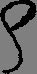

In [53]:
image_path = '/content/dataset/BasicFinalDatabase/Train/218/bcc000030.bmp'
predict_from_all_models(
    image_path=image_path,
    model_lenet=model_lenet,
    model_vgg=model_vgg,
    model_resnet=model_resnet,
    model_googlenet=model_googlenet,
    char_map=bengali_char_map
)
